In [20]:
import numpy as np
import matplotlib.pyplot as plt
import esn
from esn import EchoStateNetwork, LeastMeanSquares
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from tensorflow.keras.datasets import mnist

import importlib



In [2]:
# load mnist data 
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.reshape(-1, 28*28)
x_test = x_test.reshape(-1, 28*28)

# normalize
x_train = x_train / 255
x_test = x_test / 255

permute = False
# permute
if permute:
    np.random.seed(0)
    perm = np.random.permutation(x_train.shape[1])
    inv_perm = np.argsort(perm)

    x_train = x_train[:, perm]


In [3]:
x_train_sub = x_train[:1000]
y_train_sub = y_train[:1000]
x_valid_sub = x_train[1000:2000]
y_valid_sub = y_train[1000:2000]

x_test_sub = x_test[:1000]
y_test_sub = y_test[:1000]

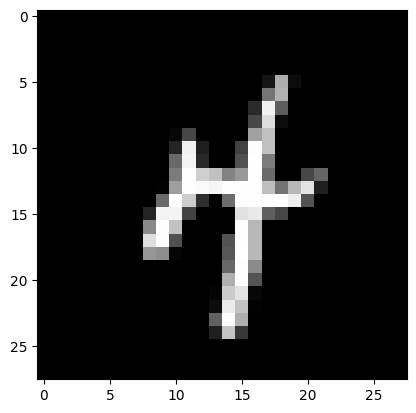

In [4]:
plt.imshow(x_train_sub[342].reshape(28, 28), cmap='gray')


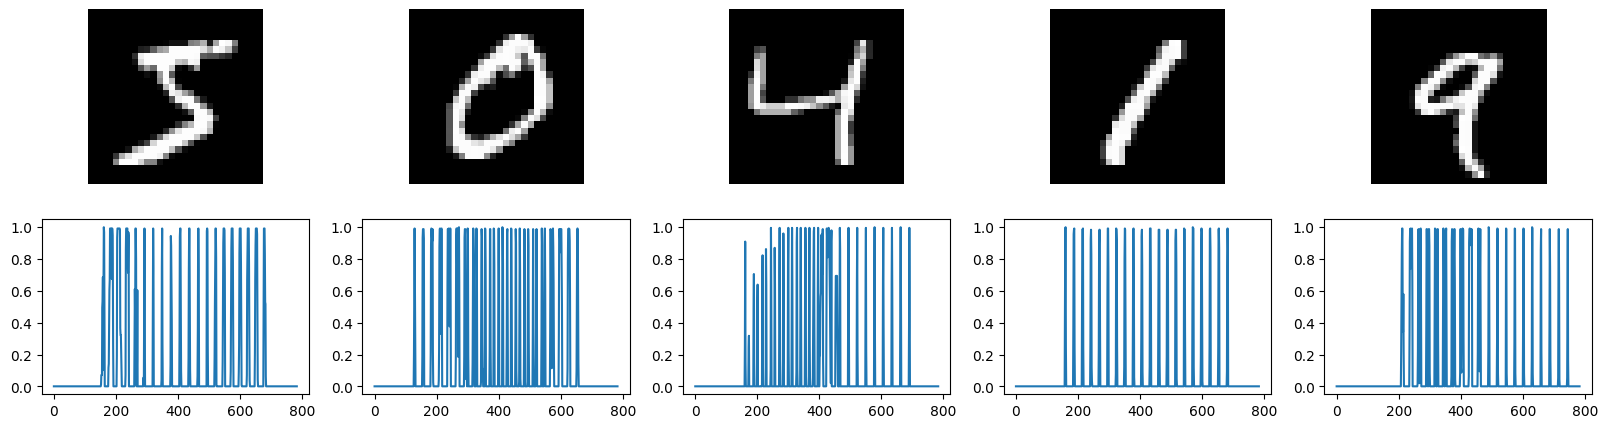

In [5]:
fig, ax = plt.subplots(2, 5, figsize=(20,5))
for i in range(5):
    ax[0, i].imshow(x_train_sub[i].reshape(28, 28), cmap='gray')
    ax[0, i].axis('off')

for i in range(5):
    ax[1, i].plot(x_train_sub[i])


In [7]:
count = 0
for x in x_train_sub:
    # count how many zeros at the end
    
    for i in range(len(x)-1, -1, -1):
        if (x[i]- 0)==0:
            count += 1
        else:
            break

# create esn


In [8]:
# create ESN
importlib.reload(esn)
from esn import EchoStateNetwork, LeastMeanSquares
esn_rnn = EchoStateNetwork(input_size=1, hidden_size=100, rho_h=0.9, omega_x= 1, head=None, density=0.1)
print(x_train_sub.shape)


(1000, 784)


In [9]:
x_train = x_train.reshape(-1, 28*28, 1)
x_train_sub = x_train_sub.reshape(-1, 28*28, 1)
hidden_states = esn_rnn.create_reservoir_batched(x_train_sub, 1)

(784, 1000, 1)


100%|██████████| 784/784 [00:16<00:00, 47.28it/s]


In [10]:
hidden_states[-1, :, -1]

array([-4.61378314e-11, -5.08847510e-12, -1.15649775e-10,  2.69618154e-10,
        2.73165844e-10, -3.28892597e-10,  2.14623739e-10,  1.19773545e-11,
       -3.20911217e-10, -4.24476551e-11,  3.11457287e-10,  4.81234996e-10,
       -1.67127140e-10,  4.16339699e-10, -1.63874105e-10, -3.92398043e-10,
        1.33184638e-10,  1.58263360e-10, -3.48124356e-10, -9.75226944e-11,
       -3.86358270e-11,  2.27823960e-10,  2.11170437e-10,  1.89972674e-10,
       -2.02465892e-10, -8.19793813e-12, -3.31126422e-11,  9.13461104e-11,
        1.29455398e-11, -8.05053084e-11,  4.34275677e-10, -5.46030830e-10,
       -9.10641252e-11, -6.52184596e-11,  1.45074924e-10, -3.85681254e-10,
        2.86368918e-10,  2.45344823e-10, -3.56831736e-10, -2.26770418e-11,
       -1.84938725e-10, -2.57582042e-10,  4.39370243e-11,  2.84627508e-10,
       -6.90318826e-11,  7.35039493e-11,  7.03053297e-11,  3.53569152e-11,
        2.28750492e-10, -1.40632386e-10, -3.09656486e-10, -9.72308702e-11,
       -1.18965374e-10, -

In [157]:
hidden_states[-1,:,1]

array([ 0.10295265,  0.76905314,  0.96165482,  0.66365325,  0.75152255,
        0.71231424,  0.70382146,  0.27832852,  0.25547363,  0.83837021,
        0.80256699,  0.86044478,  0.74585316,  0.94742594,  0.68151802,
        0.51891014,  0.7721843 ,  0.91357771,  0.97975153,  0.90267639,
        0.97481914,  0.79939712,  0.45510791,  0.30248723,  0.88647026,
        0.75816378, -0.21969465,  0.92609661,  0.86145816,  0.99105303,
        0.90507198,  0.70230107, -0.11961413,  0.81731063,  0.9134086 ,
        0.01966315,  0.86910526,  0.7474481 ,  0.89369018,  0.47954066,
        0.80691765,  0.47574947,  0.9184041 ,  0.89506645,  0.75912866,
        0.88554604,  0.56627184,  0.15710523,  0.89986542,  0.31500924,
        0.56571488,  0.76308487,  0.87251018,  0.75418712, -0.01510843,
        0.4033016 ,  0.93199849,  0.96546383,  0.935085  ,  0.43147121,
        0.47931249,  0.94541779,  0.36568524,  0.85669977,  0.84570066,
        0.9547859 ,  0.85404805,  0.74436578,  0.69699626, -0.33

In [14]:
prova = x_train_sub[0]
prova.shape

(784, 1)

In [16]:
h_prova = esn_rnn.create_reservoir(prova, 1)

In [19]:
esn_rnn.last_h 

(100, 1000)

In [17]:
h_prova.shape

(784, 100, 1000)

In [48]:
x_train_sub = x_train_sub.reshape(-1, 28*28, 1)
x_valid_sub = x_valid_sub.reshape(-1, 28*28, 1)
print(x_train_sub.shape)

(1000, 784, 1)


In [ ]:
# max pooling
washout = 0
avg_pool = np.average(hidden_states[:, washout:, :], axis=1)

max_pool = np.max(hidden_states[:, washout:, :], axis=1)
last_hidden = hidden_states[:, -1, :]
last_hidden.shape, avg_pool.shape, max_pool.shape

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=1000, penalty='l2')
logreg.fit(last_hidden, y_train_sub)
y_pred = logreg.predict(avg_pool)
accuracy_score(y_train_sub, y_pred)

In [ ]:
logreg.predict(avg_pool)

In [ ]:
# compute the accuracy
from sklearn.metrics import accuracy_score
y_train_pred = logreg.predict(hidden_states)
accuracy_score(y_train_sub, y_train_pred)


In [ ]:
# validation
val_hidden_states = []
for x_i in tqdm(x_valid_sub):
    h = esn_rnn.create_reservoir(x_i)
    val_hidden_states.append(h)

val_hidden_states = np.array(val_hidden_states)
#val_hidden_states = val_hidden_states[:,-1,:]


In [ ]:

y_valid_pred = logreg.predict(val_hidden_states.reshape(val_hidden_states.shape[0], -1))
accuracy_score(y_valid_sub, y_valid_pred)


In [ ]:
class TorchESN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, rho, omega) -> None:
        super(TorchESN, self).__init__()
        self.esn = nn.RNN(input_size=input_size, hidden_size=100, nonlinearity='tanh')
        # make rnn not learnable
        for param in self.esn.parameters():
            param.requires_grad = False
        
        self.fc = nn.Linear(hidden_size, output_size)

    def init_weights(self, rho, omega):
        # init weights at echo state property

        # input to hidden
        self.esn.weight_ih_l0.data = torch.randn_like(self.esn.weight_ih_l0.data) * omega / torch.norm(self.esn.weight_ih_l0.data, p=2)

        # hidden to hidden
        spectral_radius = torch.max(torch.abs(torch.eig(self.esn.weight_hh_l0.data)[0])).real
        self.esn.weight_hh_l0.data = torch.randn_like(self.esn.weight_hh_l0.data) * rho / spectral_radius

    


In [ ]:
esn = TorchESN(input_size=1, hidden_size=100, output_size=10, rho=1.1, omega=0.9)

In [ ]:
class LSTMnist(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers) -> None:
        super(LSTMnist, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=n_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        x, _ = self.lstm(x)
        output = self.fc(x[:,-1,:])
        return output, x

In [ ]:
x_train_sub = torch.tensor(x_train_sub, dtype=torch.float32)
y_train_sub = torch.tensor(y_train_sub, dtype=torch.long)

x_valid_sub = torch.tensor(x_valid_sub, dtype=torch.float32)
y_valid_sub = torch.tensor(y_valid_sub, dtype=torch.long)

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(x_train_sub, y_train_sub)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(x_valid_sub, y_valid_sub)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:

model = LSTMnist(28*28, 100, 10, 1)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
epochs = 10
running_loss = 0
loop = tqdm( range(epochs))
for epoch in loop:
    hs=[]
    n_seen = 0
    running_loss = 0
    loop.set_description(f'Epoch {epoch}')
    for x, y_true in train_loader:
        x = x.unsqueeze(1)
        optimizer.zero_grad()
        y, h = model(x)
        hs.append(h)
        loss = criterion(y, y_true)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        n_seen += x.shape[0]
        loop.set_postfix(loss=running_loss/n_seen)
        





In [ ]:
hs = torch.cat(hs, dim=0)

In [ ]:
hs.shape

In [ ]:
from sklearn.decomposition import FastICA as ICA
pca = ICA(n_components=2)
pca.fit(hs.reshape(1000, -1).detach().numpy())
pca_hidden = pca.transform(hs.reshape(1000, -1).detach().numpy())

plt.scatter(pca_hidden[:, 0], pca_hidden[:, 1], c=y_train_sub[:1000], cmap='tab10')




In [ ]:
# validation
model.eval()
n_seen = 0
running_loss = 0

y_pred = []
y_true = []

for x, y_true_batch in val_loader:
    x = x.unsqueeze(1)
    y, _ = model(x)
    loss = criterion(y, y_true_batch)
    running_loss += loss.item()
    n_seen += x.shape[0]
    loop.set_postfix(loss=running_loss/n_seen)
    y_pred.append(y.argmax(1))
    y_true.append(y_true_batch)

y_pred = torch.cat(y_pred)
y_true = torch.cat(y_true)
from sklearn.metrics import accuracy_score
accuracy_score(y_true, y_pred)


# SharePricesIncrease

In [92]:
def read_share_prices():
    path = "../datasets/SharePriceIncrease/SharePriceIncrease_"
    path_train = path + "TRAIN.ts"
    path_test = path + "TEST.ts"
    #read the training data
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    with open(path_train, 'r') as f:
        # start after seeing a line with @data
        start = False
        for line in f:
            if start:
                x, y = line.split(':')
                x = list(x.split(','))
                x_train.append(x)
                y_train.append(int(y))
            if line.startswith('@data'):
                start = True
    with open(path_test, 'r') as f:
        # start after seeing a line with @data
        start = False
        for line in f:
            if start:
                x, y = line.split(':')
                x = list(x.split(','))
                x_test.append(x)
                y_test.append(int(y))
            if line.startswith('@data'):
                start = True
    # convert to numpy arrays
    x_train = np.array(x_train, dtype=float)
    y_train = np.array(y_train, dtype=int)
    x_test = np.array(x_test, dtype=float)
    y_test = np.array(y_test, dtype=int)
    return x_train, y_train, x_test, y_test

In [263]:
x_train, y_train, x_test, y_test = read_share_prices()

In [264]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((965, 60), (965,), (966, 60), (966,))

In [265]:
# train - val split
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=0)
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((772, 60), (772,), (193, 60), (193,))

In [266]:
importlib.reload(esn)
from esn import EchoStateNetwork, LeastMeanSquares
esn_rnn = EchoStateNetwork(input_size=1, hidden_size=100, rho_h=0.9, omega_x= 1, head=None, density=0.1)

In [267]:
x_train= x_train.reshape(-1, 60, 1)
hidden_states = esn_rnn.create_reservoir_batched(x_train, 1)

(60, 772, 1)


100%|██████████| 60/60 [00:00<00:00, 67.80it/s]


In [268]:
hidden_states.shape

(60, 100, 772)

In [269]:
last_hidden = hidden_states[:, -1, :]

In [270]:
last_hidden[:,0]

array([ 0.        ,  0.        , -0.00464409, -0.25450445, -0.10527986,
        0.11445602, -0.1300579 , -0.01614793,  0.05981341,  0.20945987,
       -0.03906575, -0.08760525,  0.00554516, -0.1970293 , -0.26608996,
        0.29326827,  0.16164098,  0.01302889, -0.04842727, -0.07370714,
        0.20194873,  0.10390028,  0.05644212, -0.08814772, -0.05679032,
        0.13985093,  0.03174004, -0.06543804, -0.34130152,  0.15834666,
        0.00901316,  0.09625564, -0.11765153,  0.23882258,  0.05183556,
       -0.12881098, -0.16143594, -0.20898946,  0.22931838, -0.12851209,
       -0.11924877,  0.23619673,  0.27662109, -0.13258791, -0.03825398,
       -0.09120666, -0.27498437,  0.02781805,  0.19713312, -0.14420199,
       -0.17737929, -0.13811258,  0.13975819,  0.28135153,  0.15838835,
       -0.20494005,  0.12655606,  0.08959621, -0.09633425, -0.09445736])

In [271]:
last_hidden[:,1]

array([ 0.00000000e+00,  0.00000000e+00, -1.59446443e-03, -1.40054368e-01,
        9.50982895e-02,  3.96251422e-02, -1.65288592e-01,  1.05715948e-02,
        4.05031156e-02,  2.57258198e-01, -3.02066139e-02, -1.85351793e-01,
       -2.59509239e-01,  2.87740610e-01,  1.27344668e-01, -1.62677545e-01,
       -1.13274391e-01,  1.47266059e-01, -3.65783883e-02, -1.28499324e-01,
        4.39567616e-02,  9.85497765e-02, -1.59845361e-01,  2.19727661e-01,
        1.90975073e-01,  9.67005915e-02, -3.13413157e-01,  2.76321340e-02,
        7.92207353e-02, -1.15764065e-01, -1.46237407e-01,  5.08983337e-03,
       -6.38953255e-02,  6.31064503e-02, -1.18338882e-01,  1.08937032e-01,
        6.33696255e-02, -6.78541724e-02,  1.31415269e-01, -1.40091097e-01,
       -1.27394523e-01,  2.29932163e-01,  3.62439847e-01, -3.07212980e-01,
       -1.74642385e-01,  2.70426345e-01,  2.72506843e-01, -2.47041167e-01,
        4.97797886e-02,  5.41431756e-02, -1.43224076e-01, -7.52722795e-03,
        1.29358852e-01,  

In [275]:
logreg = LogisticRegression(max_iter=1000, penalty='l2')
print(last_hidden.shape, y_train.shape)
logreg.fit(last_hidden.T, y_train)
y_pred = logreg.predict(last_hidden.T)

(60, 772) (772,)


In [278]:
# weight the ones double the zeros
sample_weights = np.ones_like(y_train)
sample_weights[y_train==1] = 2

In [279]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(n_estimators=10, max_depth=6 )
rf.fit(last_hidden.T, y_train, sample_weight=sample_weights)
y_pred = rf.predict(last_hidden.T)

In [280]:
from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(y_train, y_pred))
print(confusion_matrix(y_train, y_pred))


              precision    recall  f1-score   support

           0       0.88      0.98      0.93       538
           1       0.93      0.69      0.79       234

    accuracy                           0.89       772
   macro avg       0.90      0.83      0.86       772
weighted avg       0.89      0.89      0.88       772

[[525  13]
 [ 72 162]]


In [281]:
# validation

x_val = x_val.reshape(-1, 60, 1)
val_hidden_states = esn_rnn.create_reservoir_batched(x_val, 1)
val_last_hidden = val_hidden_states[:, -1, :]
y_val_pred = rf.predict(val_last_hidden.T)
print(classification_report(y_val, y_val_pred))
print(confusion_matrix(y_val, y_val_pred))

(60, 193, 1)


100%|██████████| 60/60 [00:00<00:00, 297.04it/s]

              precision    recall  f1-score   support

           0       0.66      0.89      0.76       125
           1       0.42      0.15      0.22        68

    accuracy                           0.63       193
   macro avg       0.54      0.52      0.49       193
weighted avg       0.57      0.63      0.57       193

[[111  14]
 [ 58  10]]
